In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# !source /content/drive/MyDrive/vir_env/bin/activate;

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
# import tensorflow_datasets as tfds
# # import tensorflow_text as tf_text

from keras.callbacks import EarlyStopping
my_callbacks = [EarlyStopping(patience=2, monitor="accuracy")]

from sklearn.metrics import f1_score, classification_report

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re
import pandas as pd

import pickle

In [ ]:
cd '/content/drive/MyDrive/Berkeley/w266/'

/content/drive/MyDrive/Berkeley/w266


In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec  5 19:17:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec  5 19:17:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
file_path = 'data/'
train_df = pd.read_csv(file_path+'train_df_review.csv')
test_df = pd.read_csv(file_path+'test_df_review.csv')
val_df = pd.read_csv(file_path+'val_df_review.csv')

In [ ]:
train_df.head()

,claim,id,rating,original_rating,review,review_claim,new_rating,question
0,OpIndia claimed Greta Thunberg's real name is ...,1,0,false,['Link profile Link canonical Skip to co...,OpIndia claimed Greta Thunberg's real name is ...,false,"Is the claim ""OpIndia claimed Greta Thunberg's..."
1,"“38,000 prisoners were released from federal p...",2,1,misleading,['Link profile Link canonical Link shor...,"“38,000 prisoners were released from federal p...",misleading,"Is the claim ""“38,000 prisoners were released ..."
2,Says Wisconsin ‘could compel’ Foxconn to insta...,3,1,barely-true,['The Poynter Institute Menu Donate ...,Says Wisconsin ‘could compel’ Foxconn to insta...,misleading,"Is the claim ""Says Wisconsin ‘could compel’ Fo..."
3,A 4-year-old boy was accused of hacking the FB...,4,0,false,['Link canonical Link shortlink Snopes c...,A 4-year-old boy was accused of hacking the FB...,false,"Is the claim ""A 4-year-old boy was accused of ..."
4,Whistleblower accusing Philippine VP of fraud ...,5,1,misleading,['Link profile Link canonical Link shor...,Whistleblower accusing Philippine VP of fraud ...,misleading,"Is the claim ""Whistleblower accusing Philippin..."


In [ ]:
from transformers import BertTokenizer, TFBertModel

from transformers import logging
logging.set_verbosity_error()

**Claim + Review**

change max Legnth to 700

In [ ]:
checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)

field = 'claim'


dummy_train_y = np.array(pd.get_dummies(train_df['new_rating']))
dummy_valid_y = np.array(pd.get_dummies(val_df['new_rating']))
dummy_test_y = np.array(pd.get_dummies(test_df['new_rating']))


train_examples = train_df[field].values.tolist()
train_examples = tf.convert_to_tensor(train_examples)
train_labels = np.array(train_df['rating'].values.tolist())


test_examples = test_df[field].values.tolist()
test_examples = tf.convert_to_tensor(test_examples)
test_labels = np.array(test_df['rating'].values.tolist())



val_examples = val_df[field].values.tolist()
val_examples = tf.convert_to_tensor(val_examples)
val_labels = np.array(val_df['rating'].values.tolist())

MAX_SEQUENCE_LENGTH = 300                 # set max_length of the input sequence

all_train_examples = [x.decode('utf-8') for x in train_examples.numpy()]
all_test_examples = [x.decode('utf-8') for x in val_examples.numpy()]

x_train = bert_tokenizer(all_train_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_labels

x_test = bert_tokenizer(all_test_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = val_labels

**1 CNN layer**

*Review*

In [ ]:

import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


def create_bert_cnn_classification_model(bert_model,
                                         num_train_layers=12,
                                         hidden_size=200,
                                         dropout=0.3,
                                         cnn_filters=128,
                                         cnn_kernel_size=3,
                                         learning_rate=0.00005):
    if num_train_layers == 0:
        bert_model.trainable = False
    elif num_train_layers == 12:
        bert_model.trainable = True
    else:
        retrain_layers = ['_' + str(11 - retrain_layer_number) for retrain_layer_number in range(num_train_layers)]
        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]

    # Adding a Convolutional Neural Network (CNN) layer
    cnn_layer = tf.keras.layers.Conv1D(filters=cnn_filters, kernel_size=cnn_kernel_size, activation='relu')(bert_out[0])

    # Global Max Pooling to reduce dimensionality
    cnn_max_pooling = tf.keras.layers.GlobalMaxPooling1D()(cnn_layer)

    # Concatenate BERT pooler output with CNN max pooling
    concatenated_features = tf.keras.layers.Concatenate()([pooler_token, cnn_max_pooling])

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(concatenated_features)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(3, activation='softmax', name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.categorical_crossentropy,
                                 metrics=['accuracy',f1_metric])

    return classification_model


In [ ]:
bert_model = TFBertModel.from_pretrained(checkpoint)
bert_classification_model_claim = create_bert_cnn_classification_model(bert_model, num_train_layers=12)
bert_classification_model_claim.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 300)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 300)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 300)]                0         []                            
 tLayer)                                                                                      

In [ ]:
bert_classification_model_claim_history = bert_classification_model_claim.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    dummy_train_y,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], dummy_valid_y),
    batch_size=16,
    epochs=5, callbacks=my_callbacks)

Epoch 1/5
1686/1686 [==============================] - 608s 340ms/step - loss: 0.8650 - accuracy: 0.6034 - f1_metric: 0.5565 - val_loss: 0.8380 - val_accuracy: 0.6130 - val_f1_metric: 0.5927
Epoch 2/5
1686/1686 [==============================] - 569s 338ms/step - loss: 0.7810 - accuracy: 0.6495 - f1_metric: 0.6205 - val_loss: 0.8501 - val_accuracy: 0.6014 - val_f1_metric: 0.5853
Epoch 3/5
1686/1686 [==============================] - 569s 338ms/step - loss: 0.6417 - accuracy: 0.7217 - f1_metric: 0.7114 - val_loss: 0.9147 - val_accuracy: 0.6029 - val_f1_metric: 0.5947
Epoch 4/5
1686/1686 [==============================] - 569s 338ms/step - loss: 0.4280 - accuracy: 0.8341 - f1_metric: 0.8323 - val_loss: 1.2179 - val_accuracy: 0.5902 - val_f1_metric: 0.5859
Epoch 5/5
1686/1686 [==============================] - 569s 338ms/step - loss: 0.2405 - accuracy: 0.9122 - f1_metric: 0.9123 - val_loss: 1.5025 - val_accuracy: 0.5697 - val_f1_metric: 0.5677


In [ ]:
bert_claim_score = bert_classification_model_claim.evaluate([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],dummy_train_y)
print("%s: %.2f%%" % (bert_classification_model_claim.metrics_names[1], bert_claim_score[1]*100))

843/843 [==============================] - 188s 223ms/step - loss: 0.0872 - accuracy: 0.9755 - f1_metric: 0.9753
accuracy: 97.55%


In [ ]:
# from sklearn.metrics import classification_report

all_test_t_examples = [x.decode('utf-8') for x in test_examples.numpy()]

x_test = bert_tokenizer(all_test_t_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

y_pred = bert_classification_model_claim.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_labels, y_pred_bool))

53/53 [==============================] - 25s 409ms/step
              precision    recall  f1-score   support

           0       0.67      0.52      0.59      1461
           1       0.56      0.71      0.63      1545
           2       0.31      0.26      0.29       367

    accuracy                           0.58      3373
   macro avg       0.52      0.50      0.50      3373
weighted avg       0.58      0.58      0.57      3373



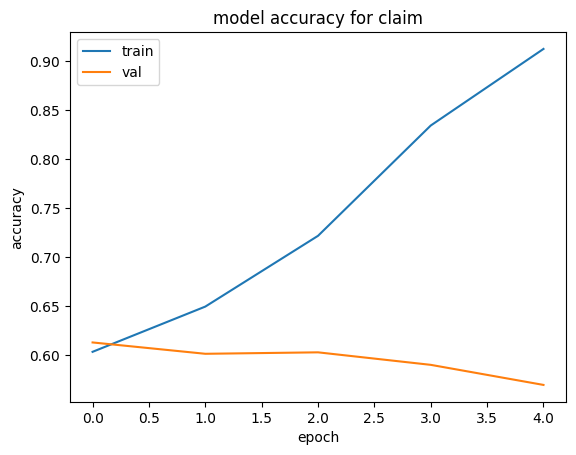

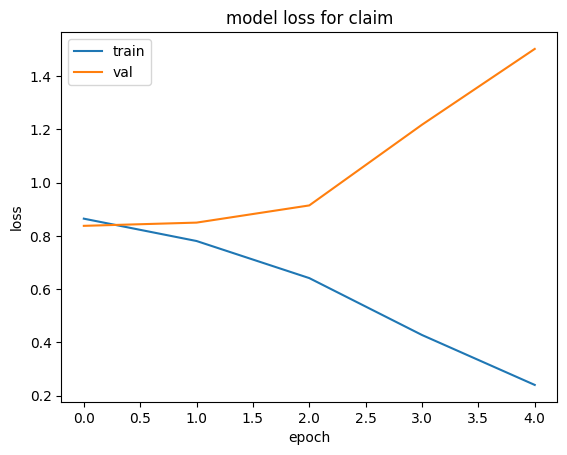

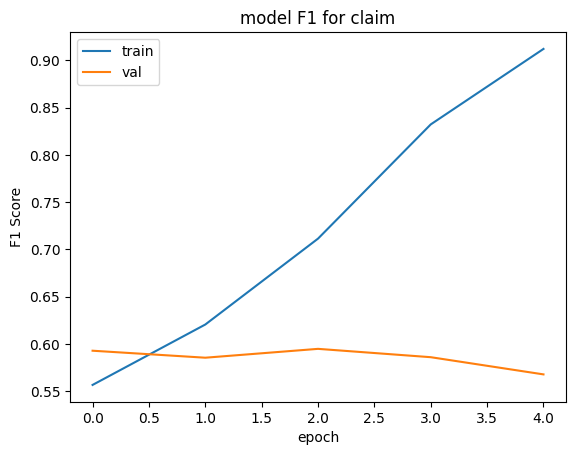

In [ ]:


# summarize history for accuracy
plt.plot(bert_classification_model_claim_history.history['accuracy'])
plt.plot(bert_classification_model_claim_history.history['val_accuracy'])
plt.title('model accuracy for claim')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(bert_classification_model_claim_history.history['loss'])
plt.plot(bert_classification_model_claim_history.history['val_loss'])
plt.title('model loss for claim')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for F1
plt.plot(bert_classification_model_claim_history.history['f1_metric'])
plt.plot(bert_classification_model_claim_history.history['val_f1_metric'])
plt.title('model F1 for claim')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
claim_history = bert_classification_model_claim_history.history
print(claim_history)
with open("/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_claim_f1.pkl", "wb") as f:
    pickle.dump(claim_history, f)

bert_classification_model_claim.save('/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_claim.h5')
bert_classification_model_claim.save("/content/drive/MyDrive/Berkeley/w266/final_project/model/my_model_claim")

{'loss': [0.8626109957695007, 0.7915344834327698, 0.670751690864563, 0.4779149293899536, 0.29273343086242676], 'accuracy': [0.6017941832542419, 0.6430901288986206, 0.7078143358230591, 0.8080886602401733, 0.8921633958816528], 'f1_metric': [0.5528278350830078, 0.6132426857948303, 0.6944700479507446, 0.8057011365890503, 0.8905903100967407], 'val_loss': [0.8412786722183228, 0.8306690454483032, 0.9111186861991882, 1.059590458869934, 1.3517128229141235], 'val_accuracy': [0.6026097536087036, 0.6123961806297302, 0.6052787899971008, 0.5806642770767212, 0.5720640420913696], 'val_f1_metric': [0.5359018445014954, 0.5943669080734253, 0.6000299453735352, 0.5734502077102661, 0.56889808177948]}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Only Review**

Change max length to 500

In [ ]:
checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)

field = 'review'


dummy_train_y = np.array(pd.get_dummies(train_df['new_rating']))
dummy_valid_y = np.array(pd.get_dummies(val_df['new_rating']))
dummy_test_y = np.array(pd.get_dummies(test_df['new_rating']))


train_examples = train_df[field].values.tolist()
train_examples = tf.convert_to_tensor(train_examples)
train_labels = np.array(train_df['rating'].values.tolist())


test_examples = test_df[field].values.tolist()
test_examples = tf.convert_to_tensor(test_examples)
test_labels = np.array(test_df['rating'].values.tolist())



val_examples = val_df[field].values.tolist()
val_examples = tf.convert_to_tensor(val_examples)
val_labels = np.array(val_df['rating'].values.tolist())

MAX_SEQUENCE_LENGTH = 500                 # set max_length of the input sequence

all_train_examples = [x.decode('utf-8') for x in train_examples.numpy()]
all_test_examples = [x.decode('utf-8') for x in val_examples.numpy()]

x_train = bert_tokenizer(all_train_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_labels

x_test = bert_tokenizer(all_test_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = val_labels

In [ ]:
bert_model = TFBertModel.from_pretrained(checkpoint)
bert_classification_model_review = create_bert_cnn_classification_model(bert_model, num_train_layers=0, dropout=0.5)
bert_classification_model_review.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 500)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 500)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 500)]                0         []                            
 tLayer)                                                                                    

In [ ]:
bert_classification_model_review_history = bert_classification_model_review.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    dummy_train_y,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], dummy_valid_y),
    batch_size=16,
    epochs=5, callbacks=my_callbacks)

Epoch 1/5
1686/1686 [==============================] - 403s 234ms/step - loss: 0.7905 - accuracy: 0.6727 - f1_metric: 0.6514 - val_loss: 0.3966 - val_accuracy: 0.8695 - val_f1_metric: 0.8703
Epoch 2/5
1686/1686 [==============================] - 391s 232ms/step - loss: 0.3075 - accuracy: 0.8882 - f1_metric: 0.8868 - val_loss: 0.1792 - val_accuracy: 0.9336 - val_f1_metric: 0.9322
Epoch 3/5
1686/1686 [==============================] - 392s 232ms/step - loss: 0.1852 - accuracy: 0.9312 - f1_metric: 0.9307 - val_loss: 0.1447 - val_accuracy: 0.9374 - val_f1_metric: 0.9391
Epoch 4/5
1686/1686 [==============================] - 392s 232ms/step - loss: 0.1504 - accuracy: 0.9398 - f1_metric: 0.9402 - val_loss: 0.1388 - val_accuracy: 0.9389 - val_f1_metric: 0.9395
Epoch 5/5
1686/1686 [==============================] - 392s 233ms/step - loss: 0.1347 - accuracy: 0.9473 - f1_metric: 0.9470 - val_loss: 0.1293 - val_accuracy: 0.9478 - val_f1_metric: 0.9498


In [ ]:
bert_review_score = bert_classification_model_review.evaluate([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],dummy_train_y)
print("%s: %.2f%%" % (bert_classification_model_review.metrics_names[1], bert_review_score[1]*100))
print('\n')

all_test_t_examples = [x.decode('utf-8') for x in test_examples.numpy()]

x_test = bert_tokenizer(all_test_t_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

y_pred = bert_classification_model_review.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

# run it with test data


print(classification_report(test_labels, y_pred_bool))


843/843 [==============================] - 322s 382ms/step - loss: 0.1094 - accuracy: 0.9542 - f1_metric: 0.9552
accuracy: 95.42%


53/53 [==============================] - 41s 731ms/step
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1461
           1       0.99      0.91      0.94      1545
           2       0.93      0.96      0.95       367

    accuracy                           0.94      3373
   macro avg       0.94      0.95      0.94      3373
weighted avg       0.95      0.94      0.94      3373



In [ ]:
review_history = bert_classification_model_review_history.history
print(review_history)
with open("/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_review_f1.pkl", "wb") as f:
    pickle.dump(review_history, f)

bert_classification_model_review.save('/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_review.h5')
bert_classification_model_review.save("/content/drive/MyDrive/Berkeley/w266/final_project/model/my_model_review")

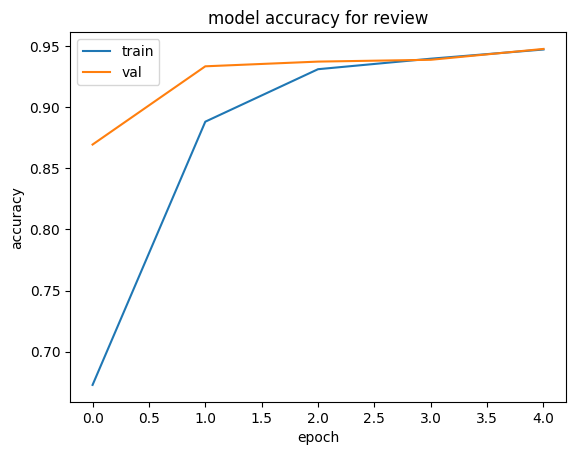

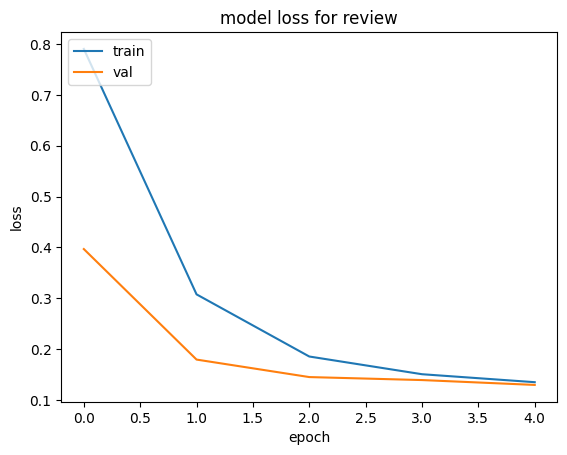

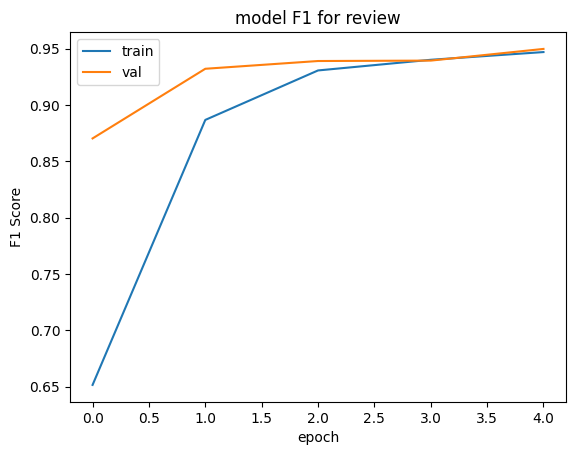

In [ ]:

# summarize history for accuracy
plt.plot(bert_classification_model_review_history.history['accuracy'])
plt.plot(bert_classification_model_review_history.history['val_accuracy'])
plt.title('model accuracy for review')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(bert_classification_model_review_history.history['loss'])
plt.plot(bert_classification_model_review_history.history['val_loss'])
plt.title('model loss for review')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for F1
plt.plot(bert_classification_model_review_history.history['f1_metric'])
plt.plot(bert_classification_model_review_history.history['val_f1_metric'])
plt.title('model F1 for review')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

** Running only for Claim**

In [ ]:
checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)

field = 'review_claim'


dummy_train_y = np.array(pd.get_dummies(train_df['new_rating']))
dummy_valid_y = np.array(pd.get_dummies(val_df['new_rating']))
dummy_test_y = np.array(pd.get_dummies(test_df['new_rating']))


train_examples = train_df[field].values.tolist()
train_examples = tf.convert_to_tensor(train_examples)
train_labels = np.array(train_df['rating'].values.tolist())


test_examples = test_df[field].values.tolist()
test_examples = tf.convert_to_tensor(test_examples)
test_labels = np.array(test_df['rating'].values.tolist())



val_examples = val_df[field].values.tolist()
val_examples = tf.convert_to_tensor(val_examples)
val_labels = np.array(val_df['rating'].values.tolist())

MAX_SEQUENCE_LENGTH = 800                 # set max_length of the input sequence

all_train_examples = [x.decode('utf-8') for x in train_examples.numpy()]
all_test_examples = [x.decode('utf-8') for x in val_examples.numpy()]

x_train = bert_tokenizer(all_train_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_labels

x_test = bert_tokenizer(all_test_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = val_labels

In [ ]:
bert_model = TFBertModel.from_pretrained(checkpoint)
bert_classification_model_claim_review = create_bert_cnn_classification_model(bert_model, num_train_layers=0, dropout=0.5)
bert_classification_model_claim_review.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 800)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 800)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 800)]                0         []                            
 tLayer)                                                                                    

In [ ]:
bert_classification_model_claim_review_history = bert_classification_model_claim_review.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    dummy_train_y,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], dummy_valid_y),
    batch_size=16,
    epochs=5, callbacks=my_callbacks)

Epoch 1/5
1686/1686 [==============================] - 718s 421ms/step - loss: 0.8001 - accuracy: 0.6635 - f1_metric: 0.6364 - val_loss: 0.4742 - val_accuracy: 0.8286 - val_f1_metric: 0.8385
Epoch 2/5
1686/1686 [==============================] - 707s 419ms/step - loss: 0.3704 - accuracy: 0.8590 - f1_metric: 0.8566 - val_loss: 0.2238 - val_accuracy: 0.9267 - val_f1_metric: 0.9245
Epoch 3/5
1686/1686 [==============================] - 707s 419ms/step - loss: 0.2128 - accuracy: 0.9252 - f1_metric: 0.9244 - val_loss: 0.1560 - val_accuracy: 0.9451 - val_f1_metric: 0.9446
Epoch 4/5
1686/1686 [==============================] - 707s 419ms/step - loss: 0.1520 - accuracy: 0.9434 - f1_metric: 0.9445 - val_loss: 0.1346 - val_accuracy: 0.9511 - val_f1_metric: 0.9519
Epoch 5/5
1686/1686 [==============================] - 707s 419ms/step - loss: 0.1306 - accuracy: 0.9510 - f1_metric: 0.9511 - val_loss: 0.1201 - val_accuracy: 0.9540 - val_f1_metric: 0.9529


In [ ]:
bert_claim_review_score = bert_classification_model_claim_review.evaluate([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],dummy_train_y)
print("%s: %.2f%%" % (bert_classification_model_claim_review.metrics_names[1], bert_claim_review_score[1]*100))
print('\n')

all_test_t_examples = [x.decode('utf-8') for x in test_examples.numpy()]

x_test = bert_tokenizer(all_test_t_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

y_pred = bert_classification_model_claim_review.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

# run it with test data


print(classification_report(test_labels, y_pred_bool))


843/843 [==============================] - 573s 680ms/step - loss: 0.0993 - accuracy: 0.9604 - f1_metric: 0.9607
accuracy: 96.04%


53/53 [==============================] - 71s 1s/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1461
           1       0.96      0.93      0.95      1545
           2       0.98      0.93      0.95       367

    accuracy                           0.95      3373
   macro avg       0.96      0.95      0.95      3373
weighted avg       0.95      0.95      0.95      3373



In [ ]:
claim_review_history = bert_classification_model_claim_review_history.history
print(claim_review_history)
with open("/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_claim_review_f1.pkl", "wb") as f:
    pickle.dump(claim_review_history, f)

bert_classification_model_claim_review.save('/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_claim_review.h5')
bert_classification_model_claim_review.save("/content/drive/MyDrive/Berkeley/w266/final_project/model/my_model_claim_review")

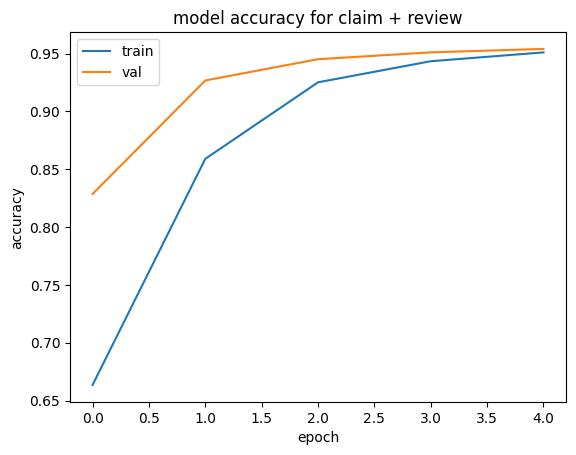

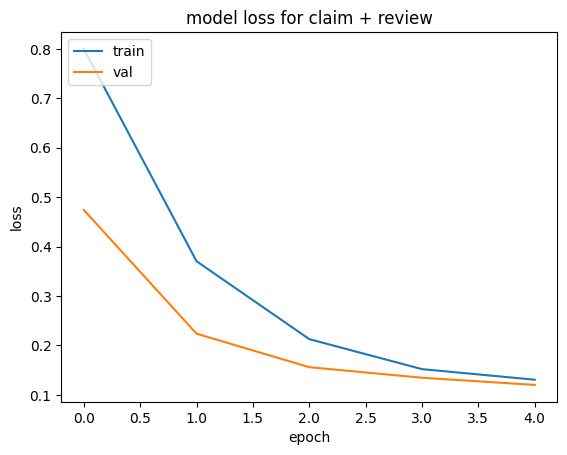

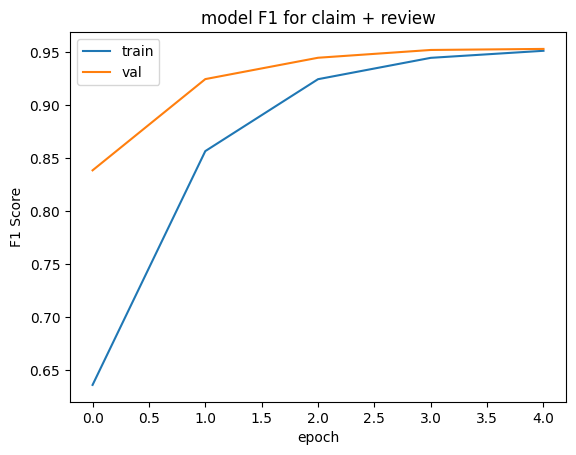

In [ ]:

# summarize history for accuracy
plt.plot(bert_classification_model_claim_review_history.history['accuracy'])
plt.plot(bert_classification_model_claim_review_history.history['val_accuracy'])
plt.title('model accuracy for claim + review')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(bert_classification_model_claim_review_history.history['loss'])
plt.plot(bert_classification_model_claim_review_history.history['val_loss'])
plt.title('model loss for claim + review')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for F1
plt.plot(bert_classification_model_claim_review_history.history['f1_metric'])
plt.plot(bert_classification_model_claim_review_history.history['val_f1_metric'])
plt.title('model F1 for claim + review')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

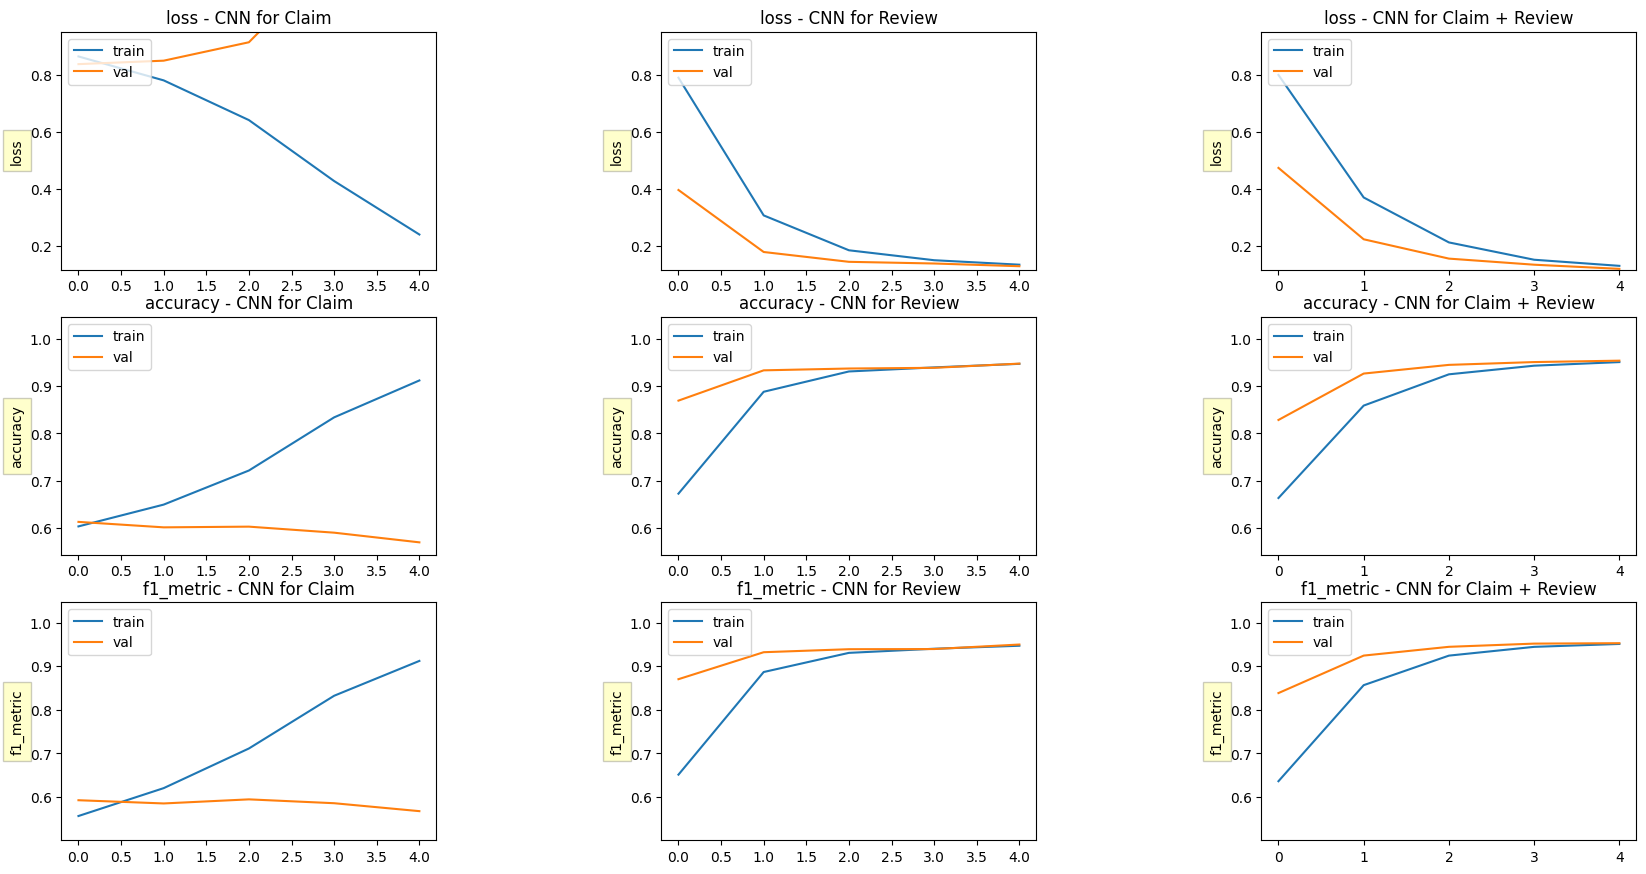

In [ ]:
# Load the training, validation loss dictionaries
# bert_classification_model_claim_history = pickle.load(open("/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_claim_f1.pkl", "rb"))
# bert_classification_model_review_history =  pickle.load(open("/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_review_f1.pkl", "rb"))
# bert_classification_model_claim_review_history =  pickle.load(open("/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_claim_review_f1.pkl", "rb"))


def make_plots(axs,
              model_history1,
              model_history2,
              model_history3,
              model_1_name='model 1',
              model_2_name='model 2',
              model_3_name='model 3',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy','f1_metric']):
        y_lim_lower1 = np.min(model_history1[metric])
        y_lim_lower2 = np.min(model_history2[metric])
        y_lim_lower3 = np.min(model_history3[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2, y_lim_lower3) * 0.9

        y_lim_upper1 = np.max(model_history1[metric])
        y_lim_upper2 = np.max(model_history2[metric])
        y_lim_upper3 = np.max(model_history3[metric])

        y_lim_upper = max(y_lim_upper1, y_lim_upper2, y_lim_upper3) * 1.1

        for j, model_history in enumerate([model_history1, model_history2, model_history3]):
            model_name = [model_1_name, model_2_name, model_3_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history[metric])
            ax1.plot(model_history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)
            ax1.legend(['train', 'val'], loc='upper left')

fig, axs = plt.subplots(3, 3)
fig.subplots_adjust(left=0.2, wspace=0.6)


make_plots(axs,
          bert_classification_model_claim_history.history,
          bert_classification_model_review_history.history,
          bert_classification_model_claim_review_history.history,
          model_1_name='CNN for Claim',
          model_2_name='CNN for Review',
          model_3_name='CNN for Claim + Review')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(22.5, 10.5)
plt.show()

All three models comparison